In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
pip install lambeq

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install lambeq[extras]

  Using cached protobuf-3.19.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.0
    Uninstalling protobuf-3.20.0:
      Successfully uninstalled protobuf-3.20.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.0 requires protobuf==3.20.0, but you have protobuf 3.19.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install cython numpy depccg

  Using cached protobuf-3.20.0-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.0 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.4
    Uninstalling protobuf-3.19.4:
      Successfully uninstalled protobuf-3.19.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.10.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install torch


Note: you may need to restart the kernel to use updated packages.


In [6]:
from lambeq import BobcatParser

/opt/conda/lib/python3.8/site-packages/lambeq/text2diagram/ccg_parser.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
pip install --upgrade lambeq

  Using cached lambeq-0.2.6-py3-none-any.whl (126 kB)
  Using cached lambeq-0.2.5-py3-none-any.whl (124 kB)
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install pytket-qiskit

Note: you may need to restart the kernel to use updated packages.


Training: Classical case

In [9]:
import torch

BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 3e-2
SEED = 0

In [10]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            val = line[0]
            value = float(val)
            labels.append([value, 1-value])
            sentences.append(line[1:].strip())
            
    return labels, sentences

# import io
# url = "manmohan sir hi.csv"
# df = pd.read_csv(url)
# print(df)

train_labels, train_data = read_data('nlpDataTrain.txt')
val_labels, val_data = read_data('nlpDataValid.txt')
test_labels, test_data = read_data('nlpDataTest.txt')

In [11]:
train_data[:5]

['cook creates complicated dish, experienced chef prepares complicated dish',
 'skilful programmer creates code, devoted hacker writes code',
 'skilful cook creates meal, devoted hacker creates complicated code',
 'hacker writes code, skilful hacker creates code',
 'devoted hacker writes code, hacker writes complicated code']

In [12]:
val_data[:5]

['cook prepares meal, chef creates meal',
 'devoted hacker writes complicated code, skilful chef creates dish',
 'programmer creates complicated code, devoted hacker creates advanced code',
 'chef creates complicated meal, skilful programmer creates advanced code',
 'skilful programmer creates complicated code, chef creates meal']

In [13]:
test_data[:5]

['cook prepares meal, chef creates meal',
 'devoted hacker writes complicated code, skilful chef creates dish',
 'programmer creates complicated code, devoted hacker creates advanced code',
 'chef creates complicated meal, skilful programmer creates advanced code',
 'skilful programmer creates complicated code, chef creates meal']

In [14]:
# Targets are represented as 2-dimensional arrays
train_labels[:5]

[[1.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 0.0]]

Creating and parameterising diagrams

The first step is to convert sentences into string diagrams.

In [15]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

train_diagrams = parser.sentences2diagrams(train_data)
val_diagrams = parser.sentences2diagrams(val_data)
test_diagrams = parser.sentences2diagrams(test_data)



Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


The produced diagrams need to be parameterised by a specific ansatz. For this experiment we will use a SpiderAnsatz.

train circuits


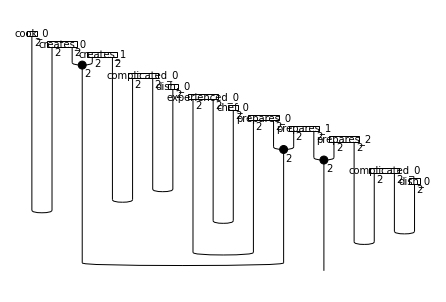

val circuits


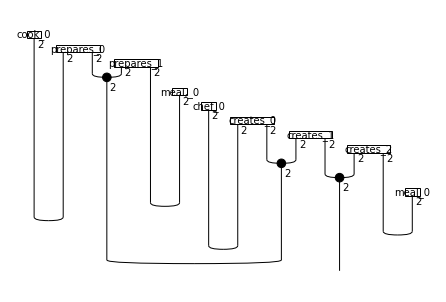

test circuits


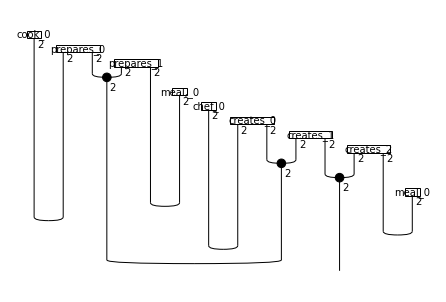

In [16]:
from discopy import Dim

from lambeq import AtomicType, SpiderAnsatz

ansatz = SpiderAnsatz({AtomicType.NOUN: Dim(2),
                       AtomicType.SENTENCE: Dim(2)})

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
val_circuits =  [ansatz(diagram) for diagram in val_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]
print("train circuits")
train_circuits[0].draw()
print("val circuits")
val_circuits[0].draw()
print("test circuits")
test_circuits[0].draw()

Instantiate the model

We can now initialise the model by importing the PytorchModel class, and passing all diagrams to the class method PytorchModel.from_diagrams().

In [17]:
from lambeq import PytorchModel

all_circuits = train_circuits + val_circuits + test_circuits
model = PytorchModel.from_diagrams(all_circuits)

In [18]:
sig = torch.sigmoid

def accuracy(y_hat, y):
    return torch.sum(torch.eq(torch.round(sig(y_hat)), y))/len(y)/2  # half due to double-counting

eval_metrics = {"acc": accuracy}

In [19]:
# PytorchTrainer object. Because this is a binary classification task, we will use binary cross-entropy as the loss.
from lambeq import PytorchTrainer

trainer = PytorchTrainer(
        model=model,
        loss_function=torch.nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.AdamW,
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text',
        seed=SEED)

In [20]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

Train the model

In [21]:
trainer.fit(train_dataset, val_dataset, evaluation_step=1, logging_step=5)



Epoch 1:   train/loss: 0.6937   valid/loss: 0.6916   train/acc: 0.5000   valid/acc: 0.5000
Epoch 5:   train/loss: 0.6025   valid/loss: 0.5721   train/acc: 0.6040   valid/acc: 0.5625
Epoch 10:  train/loss: 0.4312   valid/loss: 0.4333   train/acc: 0.7574   valid/acc: 0.6250
Epoch 15:  train/loss: 0.1729   valid/loss: 0.1369   train/acc: 0.9307   valid/acc: 0.8750
Epoch 20:  train/loss: 0.0583   valid/loss: 0.0563   train/acc: 0.9901   valid/acc: 1.0000
Epoch 25:  train/loss: 0.0128   valid/loss: 0.0093   train/acc: 0.9950   valid/acc: 1.0000
Epoch 30:  train/loss: 0.0162   valid/loss: 0.0004   train/acc: 0.9950   valid/acc: 1.0000

Training completed!


Show results

Test accuracy: 1.0


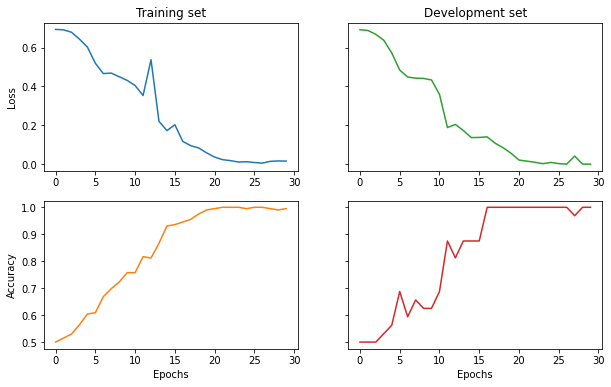

In [22]:
import matplotlib.pyplot as plt

fig1, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharey='row', figsize=(10, 6))

ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Epochs')
ax_br.set_xlabel('Epochs')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

# print test accuracy
test_acc = accuracy(model(test_circuits), torch.tensor(test_labels))
print('Test accuracy:', test_acc.item())

Adding custom layers to the model

In [23]:
class MyCustomModel(PytorchModel):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Linear(2, 2)

    def forward(self, input):
        """define a custom forward pass here"""
        preds = self.get_diagram_output(input)
        preds = self.net(preds)
        return preds

In [24]:
custom_model = MyCustomModel.from_diagrams(all_circuits)
custom_model_trainer = PytorchTrainer(
        model=custom_model,
        loss_function=torch.nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.AdamW,
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text',
        seed=SEED)
custom_model_trainer.fit(train_dataset, val_dataset, logging_step=5)

Epoch 1:   train/loss: 0.6992   valid/loss: 0.6856   train/acc: 0.4851   valid/acc: 0.5938
Epoch 5:   train/loss: 0.1006   valid/loss: 0.0002   train/acc: 0.9802   valid/acc: 1.0000
Epoch 10:  train/loss: 0.0000   valid/loss: 0.0000   train/acc: 1.0000   valid/acc: 1.0000
Epoch 15:  train/loss: 0.0000   valid/loss: 0.0000   train/acc: 1.0000   valid/acc: 1.0000
Epoch 20:  train/loss: 0.0000   valid/loss: 0.0000   train/acc: 1.0000   valid/acc: 1.0000
Epoch 25:  train/loss: 0.0000   valid/loss: 0.0000   train/acc: 1.0000   valid/acc: 1.0000
Epoch 30:  train/loss: 0.0000   valid/loss: 0.0000   train/acc: 1.0000   valid/acc: 1.0000

Training completed!


Test accuracy: 1.0


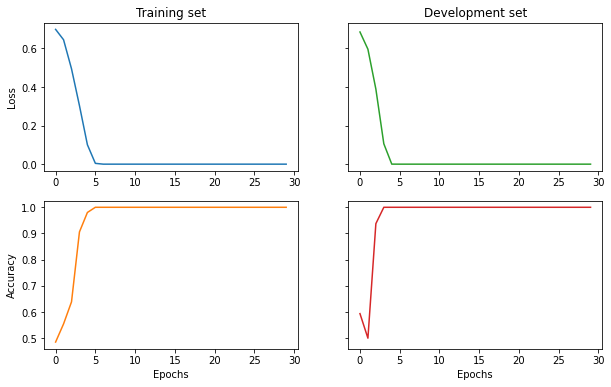

In [25]:
import matplotlib.pyplot as plt

fig1, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharey='row', figsize=(10, 6))

ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Epochs')
ax_br.set_xlabel('Epochs')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(custom_model_trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(custom_model_trainer.train_results['acc'], color=next(colours))
ax_tr.plot(custom_model_trainer.val_costs, color=next(colours))
ax_br.plot(custom_model_trainer.val_results['acc'], color=next(colours))

# print test accuracy
test_acc = accuracy(model(test_circuits), torch.tensor(test_labels))
print('Test accuracy:', test_acc.item())

Training: Quantum case


In [26]:
import os
import warnings

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'



In [27]:
import numpy as np

BATCH_SIZE = 8
EPOCHS = 1000
SEED = 2



In [28]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('nlpDataTrain.txt')
test_labels, test_data = read_data('nlpDataTest.txt')


In [29]:
train_data[:5]


['cook creates complicated dish, experienced chef prepares complicated dish',
 'skilful programmer creates code, devoted hacker writes code',
 'skilful cook creates meal, devoted hacker creates complicated code',
 'hacker writes code, skilful hacker creates code',
 'devoted hacker writes code, hacker writes complicated code']

In [30]:
test_data[:5]

['cook prepares meal, chef creates meal',
 'devoted hacker writes complicated code, skilful chef creates dish',
 'programmer creates complicated code, devoted hacker creates advanced code',
 'chef creates complicated meal, skilful programmer creates advanced code',
 'skilful programmer creates complicated code, chef creates meal']

In [31]:
train_labels[:5]



[[1, 0], [1, 0], [0, 1], [1, 0], [1, 0]]

In [32]:
test_labels[:5]

[[1, 0], [0, 1], [1, 0], [0, 1], [0, 1]]

In [ ]:
from lambeq import BobcatParser

parser = BobcatParser(root_cats=('NP', 'N'), verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)



We simplify the diagrams by calling normal_form() and filter out any diagrams that could not be parsed.

In [ ]:
train_diagrams = [
    diagram.normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
val_diagrams = [
    diagram.normal_form()
    for diagram in raw_val_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, train_labels)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(raw_val_diagrams, val_labels)
    if diagram is not None
]

In [ ]:
train_diagrams[0].draw(figsize=(9, 5), fontsize=12)

In [ ]:
train_diagrams[-1].draw(figsize=(9, 5), fontsize=12)



create circuits

In [ ]:
from lambeq import AtomicType, IQPAnsatz, remove_cups

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 0},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
val_circuits =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams]

train_circuits[0].draw(figsize=(9, 10))

In [ ]:
from discopy.drawing import equation

original_diagram = train_diagrams[0]
removed_cups_diagram = remove_cups(original_diagram)

equation(original_diagram, removed_cups_diagram, symbol='-->', figsize=(9, 6), asymmetry=0.3, fontsize=12)

Instantiate the model

In [ ]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits + val_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

We use standard binary cross-entropy as the loss

In [ ]:
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": acc}

Intialisin the trainer


    a: The initial learning rate (decays over time),

    c: The initial parameter shift scaling factor (decays over time),

    A: A stability constant, best choice is approx. 0.01 * number of training steps.


In [ ]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [ ]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)



In [ ]:
trainer.fit(train_dataset, val_dataset, evaluation_step=1, logging_step=100)



In [ ]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs[::10], color=next(colours))
ax_bl.plot(trainer.train_results['acc'][::10], color=next(colours))
ax_tr.plot(trainer.val_costs[::10], color=next(colours))
ax_br.plot(trainer.val_results['acc'][::10], color=next(colours))

# print test accuracy
test_acc = acc(model(val_circuits), val_labels)
print('Validation accuracy:', test_acc.item())